In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datetime
from hatch import create_token_batches, TokenBatch, Commons
from convictionvoting import trigger_threshold
from policies import *
from network_utils import *
from IPython.core.debugger import set_trace
from entities import Participant, Proposal
from cadCAD.configuration import Configuration

In [2]:
def update_collateral_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["collateral_pool"] = commons._collateral_pool
    return "collateral_pool", commons._collateral_pool


def update_token_supply(params, step, sL, s, _input):
    commons = s["commons"]
    s["token_supply"] = commons._token_supply
    return "token_supply", commons._token_supply


def update_funding_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["funding_pool"] = commons._funding_pool
    return "funding_pool", commons._funding_pool

In [3]:
# contributions = [5e5, 5e5, 2.5e5]
contributions = [np.random.rand() * 10e5 for i in range(60)]
token_batches, initial_token_supply = create_token_batches(contributions, 0.1, 60)

commons = Commons(sum(contributions), initial_token_supply, exit_tribute=0.35)
network = bootstrap_network(token_batches, 3, commons._funding_pool, commons._token_supply)

initial_conditions = {
    "network": network,
    "commons": commons,
    "funding_pool": commons._funding_pool,
    "collateral_pool": commons._collateral_pool,
    "token_supply": commons._token_supply,
    "sentiment": 0.5,
}

partial_state_update_blocks = [
    {
        "policies": {
            "generate_new_participants": GenerateNewParticipant.p_randomly,
        },
        'variables': {
            'network': GenerateNewParticipant.su_add_to_network,
            'commons': GenerateNewParticipant.su_add_investment_to_commons,
        }
    },
    {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
    {
        "policies": {
            "generate_new_proposals": GenerateNewProposal.p_randomly,
        },
        "variables": {
            "network": GenerateNewProposal.su_add_to_network,
        }
    },
]

In [4]:

# TODO: make it explicit that 1 timestep is 1 day
simulation_parameters = {
    'T': range(150),
    'N': 1,
    'M': {
        "sentiment_decay": 0.01, #termed mu in the state update function
        "trigger_threshold": trigger_threshold,
        "min_proposal_age_days": 7, # minimum periods passed before a proposal can pass,
        "sentiment_sensitivity": 0.75,
        "alpha": 0.5, # conviction voting parameter
        'min_supp':50, #number of tokens that must be stake for a proposal to be a candidate
    }
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )


from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc) # Do not use multi_proc, breaks ipdb.set_trace()
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7fdc669516d0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fdc669516d0>]


In [5]:
df = pd.DataFrame(raw_result)
df_final = df[df.substep.eq(2)]


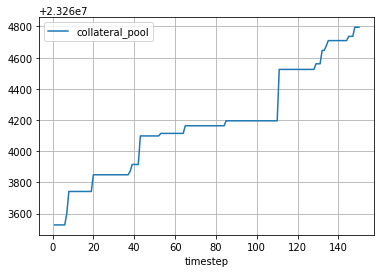

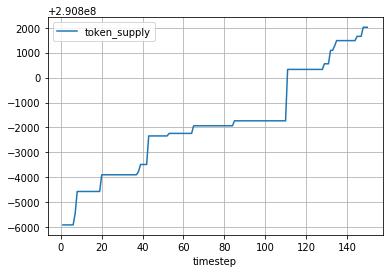

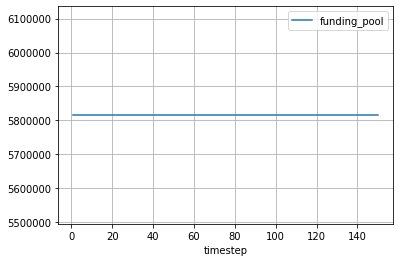

In [6]:
df_final.plot("timestep", "collateral_pool", grid=True)
df_final.plot("timestep", "token_supply", grid=True)
df_final.plot("timestep", "funding_pool", grid=True)

NetworkXError: Node (0, <Participant {'holdings_nonvesting': TokenBatch  0, Unlocked: 1.0, 'holdings_vesting': TokenBatch Hatch 4063053.204594384, Unlocked: 0, 'name': 'Somebody', 'sentiment': 0.4368260765699279}>) has no position.

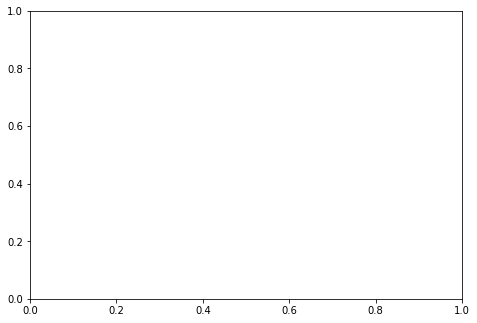

In [7]:
import matplotlib.pyplot as plt
supporters = get_edges_by_type(network, 'support')
influencers = get_edges_by_type(network, 'influence')
competitors = get_edges_by_type(network, 'conflict')

nx.draw_kamada_kawai(network, nodelist = get_participants(network), edgelist=influencers)
plt.title('Participants Social Network')